# SEIR Model 
* Na Jiang (Richard)
* Agent-Based Model for Sythetic population paper use case of disease model

## Objective
* Build an ABM to simulate the spread of disease through peoples' social networks

## TO DO
* 1 Add R0 function 
* 2 Add info related to diffrent threads of covid
* 3 Test the SEIR dynamics for different threads
* 4 Run the model for multi threads

In [1]:
import random
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import networkx as nx

## 1, Load Data & Networks

In [2]:
#Sample Population
pop = pd.read_csv('../Data/erie-data/Erie_pop_id.csv').iloc[:,1:]#.set_index('id')
print('Total population in ERIE County is:', len(pop))

Total population in ERIE County is: 900660


In [3]:
#Networks"
#hhold_networks
hhold_nw = nx.read_adjlist('../Data/erie-data/networks/hhold_nw.csv', delimiter=',')
#daycare
daycare_nw = nx.read_adjlist('../Data/erie-data/networks/daycare_nw.csv', delimiter=',')
#school
school_nw = nx.read_adjlist('../Data/erie-data/networks/school_nw.csv', delimiter=',')
#work
work_nw = nx.read_adjlist('../Data/erie-data/networks/work_nw.csv', delimiter=',')

## 2, SEIR Model
* Susceptible: all agent could be susceptible 
* Exposed: the delay of acquisition if infection and infection
* Infectious: confirmed cases
* Recovered: recover from the COVID-19
* Death: Disappear from the world

## 3, Agent-Based Model

### 3.1 Set parameter

### 3.2  Agent-Based Model, Simulation

In [4]:
from src.tools import GenBoundedRandomNormal
int(GenBoundedRandomNormal(5, 1, 1, 10))

Total population in ERIE County is: 900660
Population size 900660
Total Infected or explosed people at the beginning 2
Simulation of  30 days


5

The R0 for covid has changed over time and by variant. 
* The original covid R0 is 3-3.3 - probably closer to 3.3.  
* Delta and omicron are closer to 5. Incubation down to about 5 with delta
* I'm trying to find a good number for alpha.
* incubation 3-4 with omicron

Recovery time is highly variable.  Over 50% of people still test positive 5 days after testing positive the first time.  It ranges from about 4 days to 2 weeks or even longer for some people.  (My sister tested positive for ~ 2 weeks in December, despite having a fairly mild case.) 

### 3.2.1  Agent Class

In [5]:
# Agent class
class Agent(object):
    def __init__(self, World):        
        
        self.id = 0
        self.age = 0
        
        #hhold
        self.hhold_id = []
        self.hhold_size = []
        self.hhold_member = []
        
        #work
        self.work_id = []
        self.work_size = []
        self.work_member =[]
        
        #S, 0; E, 1; I, 2; R,3; D,4
        self.status = 0
        #Threads
        self.thread = 0 #1 is orginal; 2 is delta; 3 is omnicorn 
        self.r = 0      #R0 of different threads
        self.spread_speed = 0 #0 means can not, 1 can
        
        #incubation days
        self.incubation = 0
        self.recovery = 0
        
        #days track
        self.days = 0
        self.location = 0 #if infected in work set 1, if at home set 2
        self.when = 0;
    
    def Set_Thread_Info(self):
        #if the agent is the first day to get infected then se the incubation and r0
        if (self.status == 1) or (self.status == 2):
            #print("--Ini-- Set Thread")
            if (self.thread == 1) and (self.days == 1):
                #print("First day get Infected")
                #print("---set thread 1.., before set days:", self.days)
                self.incubation = int(GenBoundedRandomNormal(8, 2, 7, 14)) # incubation 7 to 14 days
                self.recovery = int(GenBoundedRandomNormal(7, 2, 4, 14))
                #self.r = 3
                self.r = int(GenBoundedRandomNormal(3, 1, 1, 6))
                self.days = 1
                self.spread_speed = 0.05
            
            elif (self.thread == 2) and (self.days == 1):
                self.incubation = int(GenBoundedRandomNormal(5, 2, 3, 10)) # incubation 3 to 10 days 
                self.recovery = int(GenBoundedRandomNormal(5, 2, 4, 14))
                self.r = int(GenBoundedRandomNormal(5, 1, 1, 9))
                self.days = 1
                self.spread_speed = 0.1

            elif (self.thread == 3) and (self.days == 1):
                self.incubation = int(GenBoundedRandomNormal(5, 2, 3, 10)) # incubation 3 to 10 days
                self.recovery = int(GenBoundedRandomNormal(3, 2, 4, 14))
                self.r = int(GenBoundedRandomNormal(5, 1, 1, 9))
                self.days = 1
                self.spread_speed = 0.3
            
    def Get_Infected(self, DAY):
        #print("Get_Infected...")
        #print("days", self.days)
        #print("incubation", self.incubation)
        if self.days == self.incubation: #if E reaches the incubation day
            self.status = 2
            self.days = 1
            self.when = DAY #infected day when s change from 1 to 2

    
    def Change_Thread(self, DAY):
        if (DAY >= 90) and (DAY <= 120):
            if (random.random() < 0.05): 
                if (self.status == 2) or (self.status == 1):
                    #print("change from 1 to 2")
                    if self.thread == 1:
                        self.thread = 2
                        self.Set_Thread_Info()


### 3.2.3  New World Class

In [6]:
class World(object):
    def __init__(self):
        #Number of Agnets
        self.numberOfAgent = N
        #Generate Agents list
        self.agent = [Agent(self) for i in range(self.numberOfAgent)]
    
    def Init_agents(self, pop, H, W, S, D):#population dataset, hhold network, work network, School network,, dfaycare network
        index_list = []
        id_list = []
        for i in range(self.numberOfAgent):
            index_list.append(i)
            #ID
            self.agent[i].id = str(pop.id[i])
            id_list.append(self.agent[i].id)
            #print(type(self.agent[i].id))
            #age
            self.agent[i].age = int(pop.age[i])
            
            #status
            self.agent[i].status = 0 # set healthy at the initialization
            
            #hhold
            #hhold id
            self.agent[i].hhold_id = pop.hhold[i]
            #hhold size
            self.agent[i].hhold_size = H.degree(self.agent[i].id)
            #hhold member
            self.agent[i].hhold_member = list(H.neighbors(self.agent[i].id))
            
            #work based on age and workplace ID
            self.agent[i].work_id = pop.wp[i]
            
            #Adults
            if self.agent[i].age >= 18:
                #work from home
                if self.agent[i].work_id == self.agent[i].hhold_id:
                    self.agent[i].work_size = self.agent[i].hhold_size
                    self.agent[i].work_member = self.agent[i].hhold_member
                else:
                    #work size
                    self.agent[i].work_size = W.degree(self.agent[i].id)
                    #work member
                    self.agent[i].work_member = list(W.neighbors(self.agent[i].id))
            
            #kids go to daycare
            if self.agent[i].age <= 3:
                #stay at home
                if self.agent[i].work_id == self.agent[i].hhold_id:
                    self.agent[i].work_size = self.agent[i].hhold_size
                    self.agent[i].work_member = self.agent[i].hhold_member
                #go to daycare
                else:
                    #daycare nw size
                    self.agent[i].work_size = D.degree(self.agent[i].id)
                    #work member
                    self.agent[i].work_member = list(D.neighbors(self.agent[i].id))
            
            #kids go to school 
            if (self.agent[i].age < 18) and (self.agent[i].age > 3):
                #daycare nw size
                self.agent[i].work_size = S.degree(self.agent[i].id)
                #work member
                self.agent[i].work_member = list(S.neighbors(self.agent[i].id))  
        
        id_dictionary = dict(zip(id_list, index_list))#save all agent to dictionary
        
        #set a infected agents
        #random choose five agents and set them as infected
        for j in range(NI):
            x = random.choice(range(N))
            self.agent[x].status = 2 #random.randint(1, 2) #change status to infected, ini exposed or infected
            self.agent[x].days   = 1 #first day infected
            self.agent[x].thread = 1 #the model starts with the orignial covid thread
            #self.agent[x].thread = 3
            self.agent[x].Set_Thread_Info()
            #self.agent[x].thread = random.randint(1, 2) # introducing more thread
            print("Init_agent->The Infected Nodes is ", x, "status", self.agent[x].status, "thread", self.agent[x].thread, "incubation", self.agent[x].incubation, "spread speed", self.agent[x].spread_speed)
        
        return id_dictionary
    
    #=================================================================                   
    def Home_Spread(self, id_dict, DAY):
        #Spread the disease, infected lead agent change status to 1   
        def Spread_Home_Network(indi, id_dict):
            #print("-2-In Spread_Through Home Network...")
            #print("-2.1Home-", self.agent[indi].id, "'s hhold size", self.agent[indi].hhold_size,"Status", self.agent[indi].status, "Thread:", self.agent[indi].thread, "R0", self.agent[indi].r)
            for j in range(self.agent[indi].hhold_size): 
                a_id = self.agent[indi].hhold_member[j]
                a_index = id_dict.get(a_id)
                #print("-2.1.1-id", a_id, "its index is", a_index)
                if (self.agent[a_index].status != 4):
                    #print(self.agent[a_index].id, "is not dead")
                    if random.random() < self.agent[indi].spread_speed:
                        if (self.agent[indi].thread == 1) or (self.agent[indi].thread == 2):
                            if (self.agent[a_index].status == 0):# or (self.agent[a_index].status == 3):
                                if self.agent[indi].r > 0: #check if the indi agent still can spread the disease
                                    #print("----Before", self.agent[indi].id, "'s Ro is", self.agent[indi].r)
                                    self.agent[indi].r = self.agent[indi].r - 1 #R0 - 1
                                    #print("----After", self.agent[indi].id, "'s Ro is", self.agent[indi].r)

                                    self.agent[a_index].status = 1
                                    self.agent[a_index].days = 1
                                    self.agent[a_index].location = 1 #infected at home
                                    self.agent[a_index].thread = self.agent[indi].thread #set the infected thread
                                    #print("----", self.agent[a_index].id, "get infected, thread", self.agent[a_index].thread, "days", self.agent[a_index].days)
                                    self.agent[a_index].Set_Thread_Info()
                                    
                        elif self.agent[indi].thread == 3:
                            if (self.agent[a_index].status == 0)or (self.agent[a_index].status == 3):
                                if self.agent[indi].r > 0: #check if the indi agent still can spread the disease
                                    #print("----Before", self.agent[indi].id, "'s Ro is", self.agent[indi].r)
                                    self.agent[indi].r = self.agent[indi].r - 1 #R0 - 1
                                    #print("----After", self.agent[indi].id, "'s Ro is", self.agent[indi].r)

                                    self.agent[a_index].status = 1
                                    self.agent[a_index].days = 1
                                    self.agent[a_index].location = 1 #infected at home
                                    self.agent[a_index].thread = self.agent[indi].thread #set the infected thread
                                    #print("----", self.agent[a_index].id, "get infected, thread", self.agent[a_index].thread, "days", self.agent[a_index].days)
                                    self.agent[a_index].Set_Thread_Info()
                            
        #print('-Home Networks Spread')
        for i in range(self.numberOfAgent):  
            #1
            #self.agent[i].Set_Thread_Info()#set the basic info
            #if INTRO == True:
                #self.agent[i].Change_Thread(DAY)
            #2
            if self.agent[i].status == 1:
                self.agent[i].Get_Infected(DAY)#change status from 1 to 2
            #3
            if (self.agent[i].status == 1) or (self.agent[i].status == 2):# 1 and 2 spread, then 0 become 1     
                Spread_Home_Network(i, id_dict)
                
    
    #=================================================================
    def Work_Spread(self, id_dict, DAY):
        #
        def Spread_Work_Network(indi, id_dict):
            #print("-2-In Spread_Through Home Network...")
            #print("-2.2Work-", self.agent[indi].id, "'s work size", self.agent[indi].work_size,"Status", self.agent[indi].status, "Thread:", self.agent[indi].thread, "R0", self.agent[indi].r)
            for j in range(self.agent[indi].work_size): 
                a_id = self.agent[indi].work_member[j]
                a_index = id_dict.get(a_id)
                #print("-2.1.1-id", a_id, "its index is", a_index)
                if (self.agent[a_index].status != 4):
                    #print(self.agent[a_index].id, "is not dead")
                    if random.random() < self.agent[indi].spread_speed:
                        if (self.agent[indi].thread == 1) or (self.agent[indi].thread == 2):
                            if (self.agent[a_index].status == 0):# or (self.agent[a_index].status == 3):
                                if self.agent[indi].r > 0: #check if the indi agent still can spread the disease
                                    #print("----Before", self.agent[indi].id, "'s Ro is", self.agent[indi].r)
                                    self.agent[indi].r = self.agent[indi].r - 1 #R0 - 1
                                    #print("----After", self.agent[indi].id, "'s Ro is", self.agent[indi].r)

                                    self.agent[a_index].status = 1
                                    self.agent[a_index].days = 1
                                    self.agent[a_index].location = 1 #infected at home
                                    self.agent[a_index].thread = self.agent[indi].thread #set the infected thread
                                    #print("----", self.agent[a_index].id, "get infected, thread", self.agent[a_index].thread, "days", self.agent[a_index].days)
                                    self.agent[a_index].Set_Thread_Info()
                                    
                        elif self.agent[indi].thread == 3:
                            if (self.agent[a_index].status == 0)or (self.agent[a_index].status == 3):
                                if self.agent[indi].r > 0: #check if the indi agent still can spread the disease
                                    #print("----Before", self.agent[indi].id, "'s Ro is", self.agent[indi].r)
                                    self.agent[indi].r = self.agent[indi].r - 1 #R0 - 1
                                    #print("----After", self.agent[indi].id, "'s Ro is", self.agent[indi].r)

                                    self.agent[a_index].status = 1
                                    self.agent[a_index].days = 1
                                    self.agent[a_index].location = 1 #infected at home
                                    self.agent[a_index].thread = self.agent[indi].thread #set the infected thread
                                    #print("----", self.agent[a_index].id, "get infected, thread", self.agent[a_index].thread, "days", self.agent[a_index].days)
                                    self.agent[a_index].Set_Thread_Info()


        #print('-Work Networks Spread')
        for i in range(self.numberOfAgent):  
            #1
            #self.agent[i].Set_Thread_Info()#set the basic info
            #if INTRO == True:
                #self.agent[i].Change_Thread(DAY)
                #self.agent[i].New_Thread(DAY)
            #2
            if self.agent[i].status == 1:
                self.agent[i].Get_Infected(DAY)#change status from 1 to 2
            #3
            if (self.agent[i].status == 1) or (self.agent[i].status == 2):# 1 and 2 spread, then 0 become 1     
                Spread_Work_Network(i, id_dict) 
    
    
    #=================================================================
    #def lower_case
    def Recover(self):
        for i in range(self.numberOfAgent):
            if (self.agent[i].status == 2) and (self.agent[i].days == self.agent[i].recovery):
                #print(self.agent[i].id, "Recover")
                if random.random() < 0.005:
                    self.agent[i].status = 4 #die
                else:
                    self.agent[i].status = 3 #revover
                    self.agent[i].incubation = 0 #reset incubation
                    self.agent[i].days = 0
                    
                    
    #=================================================================
    def Intro_New_Thread(self, DAY):
        #ramdom select an agent that is not 1 or 2 and assign it with new thread
        ''' 
            introduce the delta thread on day 60
            introduce the omicorn on day 120 
        
        '''
        if DAY == 30:
            
            print("change from 1 to 2...")
            for j in range(NI):
                selected = random.choice(range(N))
                print(selected)
                self.agent[selected].status = 2 #random.randint(1, 2) #change status to infected, ini exposed or infected
                self.agent[selected].days   = 1 #first day infected
                self.agent[selected].thread = 2 
                self.agent[selected].Set_Thread_Info()
                print("Intro_New_Thread->The Infected Nodes is ", selected, "status", self.agent[selected].status, "thread", self.agent[selected].thread, "incubation", self.agent[selected].incubation)

        if DAY == 90:
            print("change from 2 to 3...")
            for j in range(2):
                selected = random.choice(range(N))
                print(selected)
                self.agent[selected].status = 2 #random.randint(1, 2) #change status to infected, ini exposed or infected
                self.agent[selected].days   = 1 #first day infected
                self.agent[selected].thread = 3
                self.agent[selected].Set_Thread_Info()
                print("Intro_New_Thread->The Infected Nodes is ", selected, "status", self.agent[selected].status, "thread", self.agent[selected].thread, "incubation", self.agent[selected].incubation)


        
    #=================================================================                  
    def Update_SEIR_List(self, DAY):
        S = []
        
        E = []
        E1 = []
        E2 = []
        E3 = []
        
        I = []
        I1 = []
        I2 = []
        I3 = []
        
        R = []
        R1 = []
        R2 = []
        
        D = []
        
        T = DAY
        for i in range(self.numberOfAgent):
            #D.append(self.agent[i].days)
            
            if self.agent[i].status == 0:
                S.append(self.agent[i].id)
            
            if self.agent[i].status == 1:
                self.agent[i].days +=  1#Update Days
                
                E.append(self.agent[i].id)
                if self.agent[i].thread == 1:
                    E1.append(self.agent[i].id)
                
                elif self.agent[i].thread == 2:
                    E2.append(self.agent[i].id)

                elif self.agent[i].thread == 3:
                    E3.append(self.agent[i].id)
                      
            if self.agent[i].status == 2:
                self.agent[i].days +=  1#Update Days
                
                I.append(self.agent[i].id)
                if self.agent[i].thread == 1:
                    I1.append(self.agent[i].id)
                
                elif self.agent[i].thread == 2:
                    I2.append(self.agent[i].id)
                
                elif self.agent[i].thread == 3:
                    I3.append(self.agent[i].id)
                
            if self.agent[i].status == 3:
                R.append(self.agent[i].id)
                if self.agent[i].thread == 1:
                    R1.append(self.agent[i].id)
                
                elif self.agent[i].thread == 2:
                    R2.append(self.agent[i].id)
            
            if self.agent[i].status == 4:
                D.append(self.agent[i].id)
           
        return T, len(S), len(E), len(E1), len(E2), len(E3), len(I), len(I1), len(I2), len(I3), len(R), len(R1), len(R2), len(D)
    
    #=================================================================
    def Get_Location(self, DAY):
        Home = []
        Work = []
        Daycare = []
        School  = [] 
        T = DAY
        #print(T)
        for i in range(self.numberOfAgent):
            if self.agent[i].status == 2:
                #home
                if (self.agent[i].location == 2) and (self.agent[i].when == DAY):
                    #print("Case 1")
                    Home.append(self.agent[i].id)   
                elif (self.agent[i].location == 1) and (self.agent[i].when == DAY):
                    #print("Case 2")
                    #daycare
                    if self.agent[i].age <= 2:
                        #print("Case 2.1")
                        Daycare.append(self.agent[i].id)
                    #school
                    if (self.agent[i].age <= 17) and (self.agent[i].age >= 3): 
                        #print("Case 2.2")
                        School.append(self.agent[i].id)
                    #work
                    if self.agent[i].age >= 18:
                        #print("Case 2.3")
                        Work.append(self.agent[i].id)                
        
        return T, len(Home), len(Work), len(Daycare), len(School)
        

## 4 Simulation Results and Analysis

### 4.1 Simulation Class

In [7]:
class Sim(object):
    def __init__(self):
        self.World = World()
        self.df = pd.DataFrame([])
       
    def Run(self, H, W, S, D, DAYS):
        steps = DAYS * 3
        print("Simulation steps:", steps)
        
        id_d = self.World.Init_agents(pop, H, W, S, D) #create fullpop with pop dataset
        #print(type(id_d))
        #print(id_d)
        
        Results = []
        Location = []

        day = 0
        for i in range(0, steps):
            
            if i % 3 == 0:
                #Update SEIR
                #t, x1, x2, x3, x4, x5 = self.World.Update_SEIR_List(day)
                t, s, x, x1, x2, x3, y, y1, y2, y3, z, z1, z2, d = self.World.Update_SEIR_List(day)
                Results.append([t, s, x, x1, x2, x3, y, y1, y2, y3, z, z1, z2, d])
                
                #Get Infected Location
                time, h, w, d, s = self.World.Get_Location(day)
                Location.append([time, h, w, d, s])
                
                #print("Day:", day,"Moring")
                self.World.Home_Spread(id_d, day)
                self.World.Recover()
                
                
                if day % 10 == 0:
                    print("Current Day: ", day)
                    self.World.Intro_New_Thread(day)
                    #print(t, s, x, x1, x2, y, y1, y2, z, z1, z2, d) 
                
                day = day + 1 #update simulation day
            
            if i % 3 == 1:
                #print("Day:", day,"Daytime")
                self.World.Work_Spread(id_d, day)
                self.World.Recover() 
        
            if i % 3 == 2:
                #print("Day:", day,"Evening")
                self.World.Home_Spread(id_d, day)
                self.World.Recover()      
     
        
        #SEIR
        df1 =  pd.DataFrame(Results, columns=['Day','S', 'E', 'E1', 'E2','E3', 'I', 'I1', 'I2', 'I3', 'R', 'R1', 'R2', 'D']) 
        #Location
        df2 = pd.DataFrame(Location, columns=['Day','Home', 'Work', 'Daycare', 'School'])
        return df1, df2

## 4.2 Set Model Parametters 

In [8]:
# Number of agents
N = len(pop)
print("Population size", N)

#Number of Infected at the beginning of the simulation
NI = 2
print("Total Infected or explosed people at the beginning", NI)

#Introduce New Thred or Not
INTRO = True

#Number of Days
#DAYS = 30
DAYS = 120
print("Simulation of ", DAYS, "days")

Population size 900660
Total Infected or explosed people at the beginning 2
Simulation of  120 days


## 4.3 Simulation Experiemnt

In [ ]:
from src.simulation import Sim

if __name__ == '__main__':
    aSim = Sim()
    print ("simulation starts...")
    #Network
    H = deepcopy(hhold_nw)
    W = deepcopy(work_nw)
    S = deepcopy(school_nw)
    D = deepcopy(daycare_nw)
    SEIR, Loc = aSim.Run(H, W, S, D, DAYS)
    print("Done~")

## 4.4 Visualization of Simulation Results

### 4.4.1 SEIR Plot

In [ ]:
def plot_SEIR(df):
    print(df.head()) 
    fig, ax = plt.subplots(figsize=(25,10))
    
    #plt.figure(figsize=(25,10))
    plt.xlabel('time $t$', fontsize = 20, fontname = "Arial")
    plt.ylabel('Population', fontsize = 20, fontname = "Arial")
    
    if INTRO == False:
        plt.plot(df.index, df.S, marker='o', markerfacecolor='gray', markersize=2, color='skyblue', linewidth=2)
    
    plt.plot(df.index, df.E, marker='o', markerfacecolor='gray', markersize=2, color='yellow', linewidth=2)
    #plt.plot(df.index, df.E1, marker='*', markerfacecolor='gray', markersize= 10, color='yellow', linewidth=2)
    #plt.plot(df.index + 1, df.E2, marker='+', markerfacecolor='gray', markersize= 10, color='orange', linewidth=2)
    #plt.plot(df.index + 1, df.E3, marker='+', markerfacecolor='gray', markersize= 10, color='orange', linewidth=2)
    
    plt.plot(df.index, df.I, marker='o', markerfacecolor='gray', markersize=2, color='red', linewidth=2)
    #plt.plot(df.index, df.I1, marker='*', markerfacecolor='gray', markersize=10, color='red', linewidth=2)
    #plt.plot(df.index + 1, df.I2, marker='+', markerfacecolor='gray', markersize=10, color='pink', linewidth=2)
    #plt.plot(df.index + 1, df.I3, marker='+', markerfacecolor='gray', markersize= 10, color='darkred', linewidth=2)
    
    plt.plot(df.index, df.R, marker='o', markerfacecolor='gray', markersize=2, color='green', linewidth=2)
    #plt.plot(df.index, df.R1, marker='*', markerfacecolor='gray', markersize=10, color='green', linewidth=2)
    #plt.plot(df.index + 1, df.R2, marker='+', markerfacecolor='gray', markersize=10, color='springgreen', linewidth=2)
    
    plt.plot(df.index, df.D, marker='o', markerfacecolor='gray', markersize=2, color='black', linewidth=2)    
    #plt.legend(('Susceptible', 'Exposed', 'Infectious','Recovered', 'Dead'), prop={"size":20}, fancybox=True, framealpha=1, shadow=True,loc = 'upper right', ncol = 5)  
    plt.gcf().autofmt_xdate() #italics of x label   
    #plt.savefig('SEIR_WL.png')
    plt.show()

In [ ]:
plot_SEIR(SEIR)

   Day       S  E  E1  E2  E3  I  I1  I2  I3  R  R1  R2  D
0    0  900658  0   0   0   0  2   2   0   0  0   0   0  0
1    1  900658  0   0   0   0  2   2   0   0  0   0   0  0
2    2  900658  0   0   0   0  2   2   0   0  0   0   0  0
3    3  900658  0   0   0   0  2   2   0   0  0   0   0  0
4    4  900657  1   1   0   0  2   2   0   0  0   0   0  0


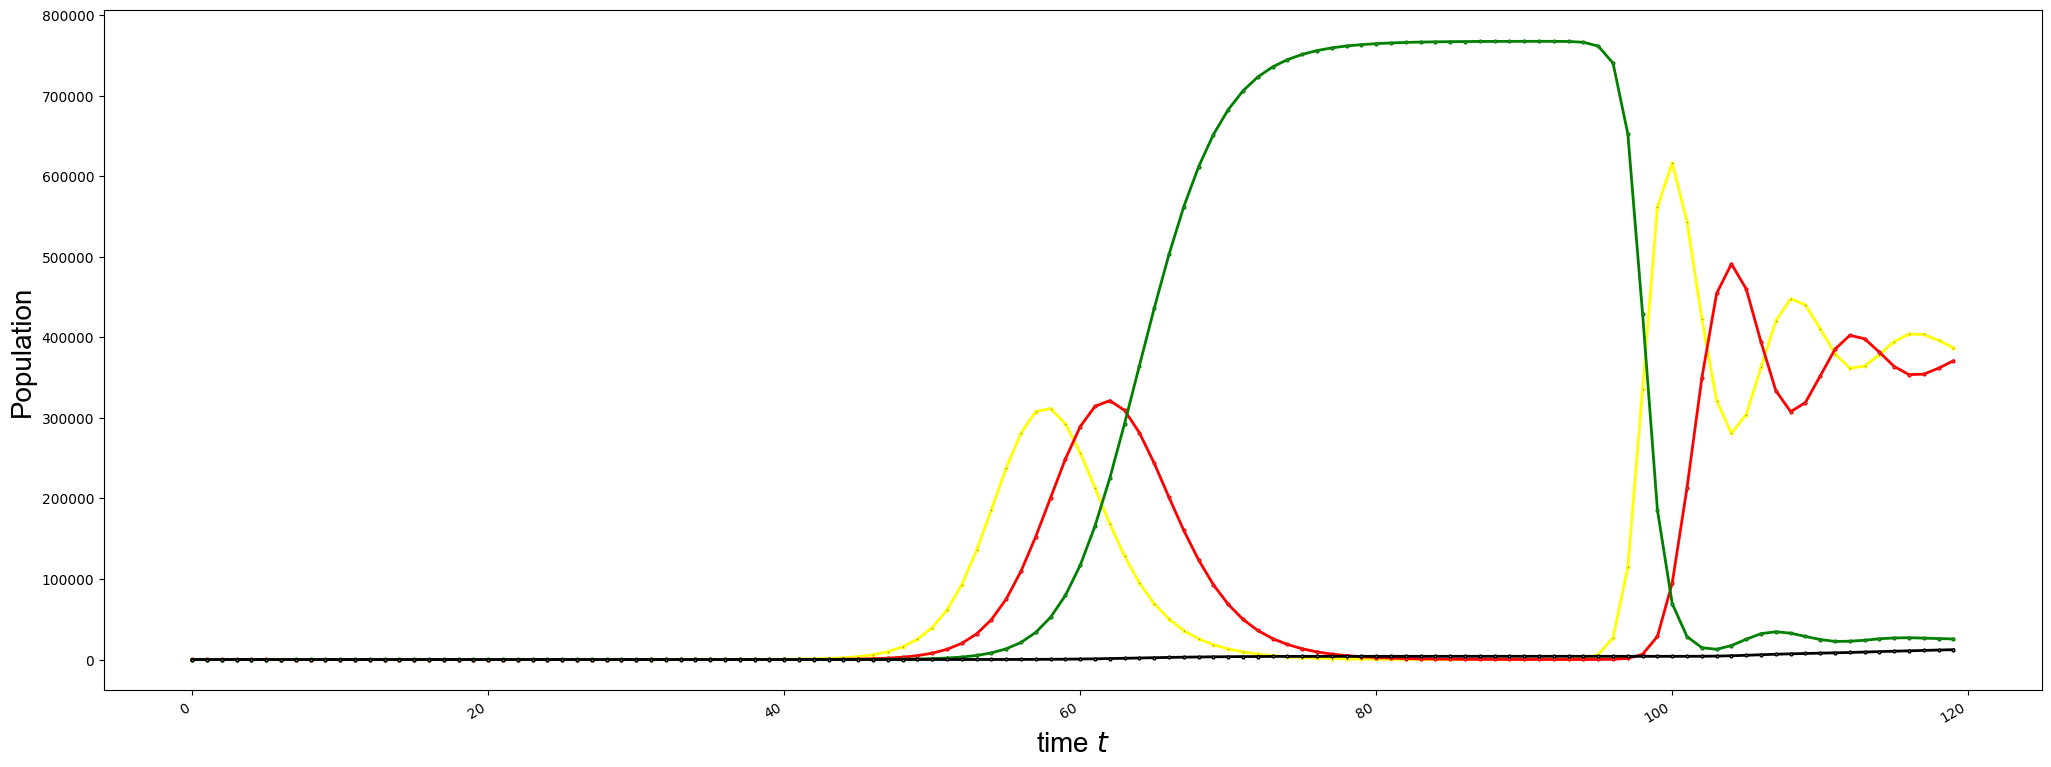

In [17]:
plot_SEIR(SEIR)

### 4.4.2 Multi Plot

In [18]:
def plot_Multi_SEIR(df):
    print(df.head()) 
    fig, ax = plt.subplots(figsize=(25,10))
    
    #plt.figure(figsize=(25,10))
    plt.xlabel('time $t$', fontsize = 20, fontname = "Arial")
    plt.ylabel('Population', fontsize = 20, fontname = "Arial")
    
    if INTRO == False:
        plt.plot(df.index, df.S, marker='o', markerfacecolor='gray', markersize=2, color='skyblue', linewidth=2)
    
    #plt.plot(df.index, df.E, marker='o', markerfacecolor='gray', markersize=2, color='yellow', linewidth=2)
    plt.plot(df.index, df.E1, marker='*', markerfacecolor='gray', markersize= 10, color='yellow', linewidth=2)
    plt.plot(df.index + 1, df.E2, marker='+', markerfacecolor='gray', markersize= 10, color='orange', linewidth=2)
    plt.plot(df.index + 1, df.E3, marker='o', markerfacecolor='gray', markersize= 10, color='gold', linewidth=2)
    
    #plt.plot(df.index, df.I, marker='o', markerfacecolor='gray', markersize=2, color='red', linewidth=2)
    plt.plot(df.index, df.I1, marker='*', markerfacecolor='gray', markersize=10, color='red', linewidth=2)
    plt.plot(df.index + 1, df.I2, marker='+', markerfacecolor='gray', markersize=10, color='pink', linewidth=2)
    plt.plot(df.index + 1, df.I3, marker='+', markerfacecolor='gray', markersize= 10, color='darkred', linewidth=2)
    
    #plt.plot(df.index, df.R, marker='o', markerfacecolor='gray', markersize=2, color='green', linewidth=2)
    #plt.plot(df.index, df.R1, marker='*', markerfacecolor='gray', markersize=10, color='green', linewidth=2)
    #plt.plot(df.index + 1, df.R2, marker='+', markerfacecolor='gray', markersize=10, color='springgreen', linewidth=2)
    
    #plt.plot(df.index, df.D, marker='o', markerfacecolor='gray', markersize=2, color='black', linewidth=2)    
    #plt.legend(('Susceptible', 'Exposed', 'Infectious','Recovered', 'Dead'), prop={"size":20}, fancybox=True, framealpha=1, shadow=True,loc = 'upper right', ncol = 5)  
    plt.gcf().autofmt_xdate() #italics of x label   
    #plt.savefig('SEIR_WL.png')
    plt.show()

In [92]:
SEIR[90:]

,Day,S,E,E1,E2,E3,I,I1,I2,I3,R,R1,R2,D
90,90,134251,125,29,96,0,551,79,472,0,769166,434845,334321,3866
91,91,134245,107,22,73,12,391,59,327,5,769346,434853,334493,3870
92,92,134233,131,15,50,66,294,35,254,5,769431,434840,334591,3870
93,93,134230,505,7,32,466,227,30,191,6,769126,434658,334468,3871
94,94,134196,2683,7,19,2657,192,23,150,19,767017,433378,333639,3871
95,95,134014,15414,4,16,15394,235,16,116,103,754425,425344,329081,3871
96,96,133026,79928,1,14,79913,717,14,89,614,690417,384566,305851,3871
97,97,128772,291728,1,13,291714,3644,12,54,3578,479944,254767,225177,3871
98,98,120072,561817,1,11,561805,18792,8,46,18738,203407,95804,107598,3871
99,99,111589,650743,1,9,650733,75268,5,29,75234,66485,26439,40019,3874


   Day       S   E  E1  E2  E3  I  I1  I2  I3  R  R1  R2  D
0    0  907957   0   0   0   0  2   2   0   0  0   0   0  0
1    1  907955   2   2   0   0  2   2   0   0  0   0   0  0
2    2  907953   4   4   0   0  2   2   0   0  0   0   0  0
3    3  907949   8   8   0   0  2   2   0   0  0   0   0  0
4    4  907946  11  11   0   0  2   2   0   0  0   0   0  0


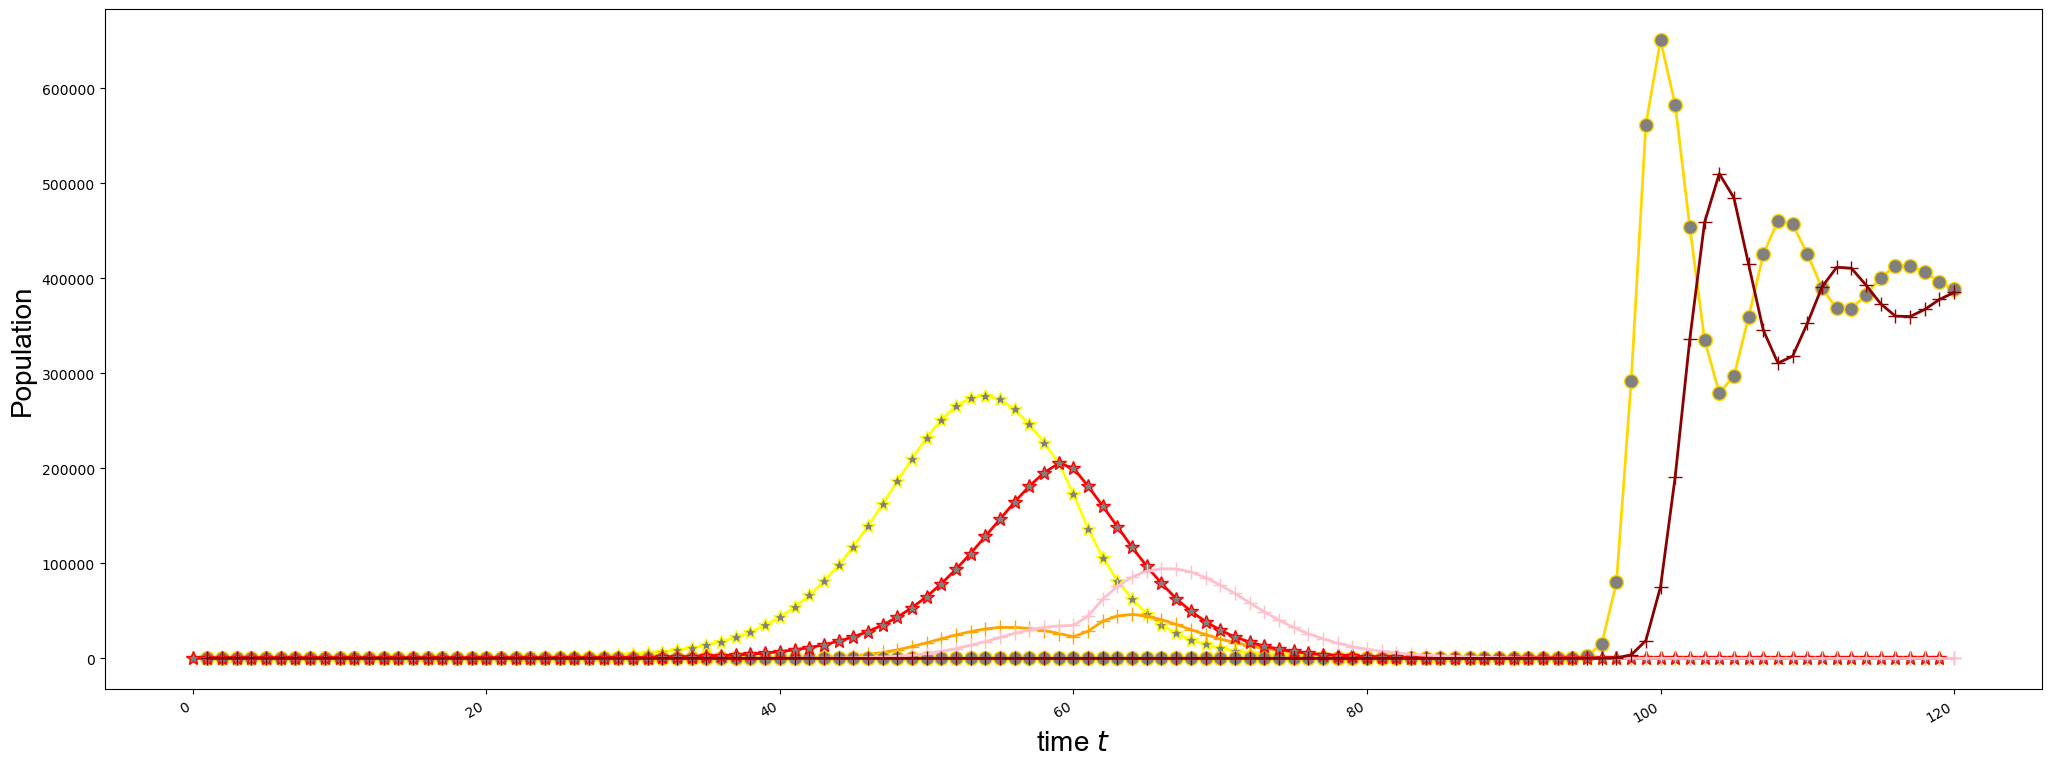

In [95]:
plot_Multi_SEIR(SEIR)

In [49]:
SEIR.I3.unique()

array([0, 2, 3, 1])

### 4.4.2 Infected Loactions

In [ ]:
def plot_Loc(df):    
    plt.figure(figsize=(25,10))
    plt.xlabel('time $t$', fontsize = 20, fontname = "Arial")
    plt.ylabel('Population', fontsize = 20, fontname = "Arial")
    #extract data
    temp1 = list(df.Home)
    temp2 = list(df.Work)
    temp3 = list(df.Daycare)
    temp4 = list(df.School)
    #New list to plot
    home = []
    work = []
    daycare = []
    school  = []
    
    for i in range(len(temp1)):
        if i == 0:
            home.append(temp1[i])
            work.append(temp2[i])
            daycare.append(temp3[i])
            school.append(temp4[i])
        if i != 0:
            h = home[i - 1] + temp1[i]
            w = work[i - 1] + temp2[i]
            d = daycare[i - 1] + temp3[i]
            s = school[i - 1] + temp4[i]
        
            home.append(h)
            work.append(w)
            daycare.append(d)
            school.append(s)
    plt.plot(df.index, home, marker='o', markerfacecolor='gray', markersize=2, color='green', linewidth=2)
    plt.plot(df.index, work, marker='o', markerfacecolor='gray', markersize=2, color='red', linewidth=2)
    plt.plot(df.index, daycare, marker='o', markerfacecolor='gray', markersize=2, color='orange', linewidth=2)
    plt.plot(df.index, school, marker='o', markerfacecolor='gray', markersize=2, color='blue', linewidth=2)      
    plt.legend(('Home', 'Work', 'Daycare','School'), prop={"size":20}, fancybox=True, framealpha=1, shadow=True,loc = 'upper left', ncol = 4)    
    plt.gcf().autofmt_xdate() #italics of x label 
    plt.savefig('Home_Work_Infected_wL.png')

In [ ]:
plot_Loc(Loc)